# Q-Learning on FrozenLake (Gymnasium)
We will use the FrozenLake-v1 environment from Gymnasium and solve it with Q-learning.


## Imports and Helpers
We import the libraries, set a random seed, and make a helper for moving averages.


In [2]:
import numpy as np
import gymnasium as gym
from collections import deque
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(0)

def moving_average(x, window=100):
    if len(x) < window:
        return np.array(x, dtype=float)
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[window:] - cumsum[:-window]) / float(window)

# Map FrozenLake actions to arrows for pretty policies
# You can write these on a mac with CMD + OPTION + SPACE
# IDK how on windows
ARROWS = {0: "←", 1: "↓", 2: "→", 3: "↑"}  # Left, Down, Right, Up 

## Environment
We use the classic **4x4 FrozenLake** environment.  
- Start = top left  
- Goal = bottom right  
- Holes = fall in, episode ends  
- Slippery ice makes actions stochastic


In [ ]:
# Classic 4x4 FrozenLake (slippery by default). Rewards: +1 for reaching goal, 0 otherwise.
# During training we don't need rendering; it's faster.
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=True)
n_states = env.observation_space.n
n_actions = env.action_space.n

n_states, n_actions


(np.int64(16), np.int64(4))

## Q-table and Hyperparameters
- **Q-table**: stores values for each state-action pair  
- **α (alpha)**: learning rate  
- **γ (gamma)**: discount factor  
- **ε (epsilon)**: exploration rate


In [4]:
Q = np.zeros((n_states, n_actions))

# Hyperparameters (good starting points for FrozenLake)
# Check out optimal parameters at sb3 github
alpha = 0.8         # learning rate
gamma = 0.95        # discount factor

epsilon = 1.0       # start fully exploring
epsilon_min = 0.01  # minimal exploration
epsilon_decay = 0.995

episodes = 10_000
max_steps_per_episode = 100

# Tracking
episode_rewards = []
episode_success = [] # 1 if reached goal, else 0
smoothed_success = []


## Epsilon-Greedy Strategy
At each step:
- With probability ε: pick a random action (explore)  
- With probability 1-ε: pick the best-known action (exploit)


In [5]:
def epsilon_greedy_action(state, epsilon):
    if np.random.rand() < epsilon:
        return env.action_space.sample()   # explore
    else:
        return int(np.argmax(Q[state]))    # exploit

## Training with Q-learning
For each episode:
1. Start at the beginning  
2. Choose actions with ε-greedy  
3. Update the Q-table using the Q-learning rule  
4. Decay ε over time  

We repeat for many episodes so the agent learns a good policy.


In [6]:
for ep in range(episodes):
    state, info = env.reset()
    total_reward = 0

    for t in range(max_steps_per_episode):
        action = epsilon_greedy_action(state, epsilon)

        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        # Q-learning update
        best_next = np.max(Q[next_state])
        td_target = reward + gamma * best_next
        td_error  = td_target - Q[state, action]
        Q[state, action] += alpha * td_error

        state = next_state
        total_reward += reward
        if done:
            break

    # Bookkeeping
    episode_rewards.append(total_reward)
    episode_success.append(1 if total_reward > 0 else 0)

    # Decay ε
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

# Compute moving average success (window=100)
smoothed_success = moving_average(episode_success, window=100)
len(Q), Q.shape


(16, (16, 4))

## Learning Curve
We plot the moving average of success rate across episodes.  
This shows if the agent is improving at reaching the goal.


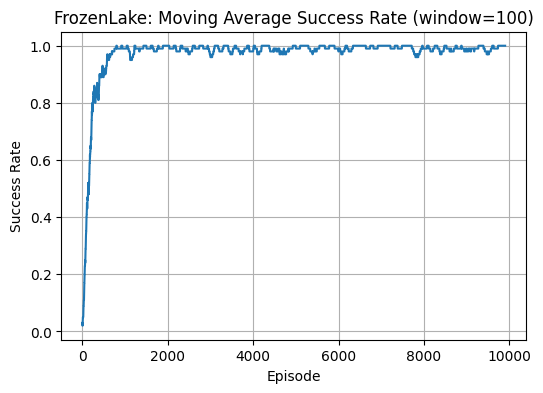

In [7]:
plt.figure(figsize=(6,4))
plt.plot(smoothed_success)
plt.title("FrozenLake: Moving Average Success Rate (window=100)")
plt.xlabel("Episode")
plt.ylabel("Success Rate")
plt.grid(True)
plt.show()


## Greedy Policy
After training, we take the **best action** from each state (highest Q-value).  
We can display it as arrows on the grid.


In [19]:
greedy_policy = np.argmax(Q, axis=1)

def render_policy(policy):
    # 4x4 grid indices: 0..15
    grid = []
    for s in range(n_states):
        a = policy[s]
        grid.append(ARROWS[a])
    return np.array(grid).reshape(4,4)

render_policy(greedy_policy)


array([['↓', '←', '←', '←'],
       ['↓', '←', '↓', '←'],
       ['→', '↓', '↓', '←'],
       ['←', '→', '→', '←']], dtype='<U1')

## Evaluate Policy
We run the greedy policy without exploration to measure its success rate.


In [ ]:
def evaluate_policy(env, policy, episodes=100, max_steps=100):
    wins = 0
    for _ in range(episodes):
        s, _ = env.reset()
        for _ in range(max_steps):
            a = int(policy[s])
            s, r, term, trunc, _ = env.step(a)
            if term or trunc:
                if r > 0:
                    wins += 1
                break
    return wins / episodes

eval_env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=True)
success_rate = evaluate_policy(eval_env, greedy_policy, episodes=500)
success_rate


1.0

## Watch an Episode
We let the trained agent play one episode and print the text rendering of the grid as it moves.


In [ ]:
# Watch one episode with real graphics
watch_env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=True, render_mode="human")

state, _ = watch_env.reset()
done = False
total_reward = 0

while not done:
    action = int(greedy_policy[state])
    state, reward, terminated, truncated, _ = watch_env.step(action)
    done = terminated or truncated
    total_reward += reward

watch_env.close()
print("Episode finished. Total reward:", total_reward)


2025-09-25 18:49:18.222 Python[29948:18390633] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/vf/pyld0zvx04942drv3gzc5nww0000gn/T/org.python.python.savedState


Episode finished. Total reward: 0


: 

In [ ]:
# Alternative video recording without Pygame
from gymnasium.wrappers import RecordVideo
from IPython.display import Video, display
from pathlib import Path

# Wrap an env for video recording. Must use render_mode="rgb_array" for RecordVideo.
video_dir = Path("videos")
video_dir.mkdir(exist_ok=True)

env_video = gym.make(
    "FrozenLake-v1",
    map_name="4x4",
    is_slippery=True,
    render_mode="rgb_array"
)
env_video = RecordVideo(
    env_video,
    video_folder=str(video_dir),
    episode_trigger=lambda ep_id: True,   # record every episode we run here
    name_prefix="frozenlake"
)

# Play one greedy episode with the learned policy and record it.
# If success is rare, try a few times; stop at the first recorded episode.
max_episodes_to_try = 5
for attempt in range(max_episodes_to_try):
    state, _ = env_video.reset()
    done = False
    total_reward = 0

    # Use the greedy policy learned earlier (from Q-table)
    steps = 0
    while not done and steps < 200:
        action = int(greedy_policy[state])  # exploit only
        state, reward, terminated, truncated, _ = env_video.step(action)
        done = terminated or truncated
        total_reward += reward
        steps += 1

    # We recorded the whole episode automatically.
    # If you want to insist on a success, you could continue the loop when total_reward == 0.
    print(f"Recorded episode {attempt+1} | total_reward={total_reward}")
    break  # remove this break if you want to try multiple recordings

env_video.close()


NameError: name 'gym' is not defined

In [16]:
# Find and display the most recent video
latest_video = sorted(Path("videos").glob("*.mp4"))[-1]
display(Video(str(latest_video), embed=True, width=480))


## Notes
- FrozenLake is **slippery**, so even a good policy doesn’t win 100% of the time.  
- More training episodes or different hyperparameters can improve results.  
- Setting `is_slippery=False` makes the task easier and deterministic.


## Q-table
We can display the learned Q-values as a table to see what the agent learned.


In [17]:
import pandas as pd
df = pd.DataFrame(Q, columns=["Left(0)","Down(1)","Right(2)","Up(3)"])
df.index.name = "State"
df.round(3)


,Left(0),Down(1),Right(2),Up(3)
State,,,,
0,0.735,0.774,0.698,0.735
1,0.735,0.000,0.663,0.698
2,0.698,0.000,0.334,0.531
3,0.617,0.000,0.334,0.000
4,0.774,0.815,0.000,0.735
5,0.000,0.000,0.000,0.000
6,0.000,0.902,0.000,0.658
7,0.000,0.000,0.000,0.000
8,0.815,0.000,0.857,0.774


## Visualize Policy
We show the arrows (best actions) in a 4x4 grid format.


In [18]:
# Print arrows in a 4x4 grid
grid_arrows = render_policy(greedy_policy)
for row in grid_arrows:
    print(" ".join(row))


↓ ← ← ←
↓ ← ↓ ←
→ ↓ ↓ ←
← → → ←
